In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Adding dataset

In [2]:
DATA_PATH = "/content/climate_change_dataset.csv"
OUT_DIR = Path("models_outputs")
OUT_DIR.mkdir(exist_ok=True)
RANDOM_STATE = 42
FUTURE_YEARS = 10

In [3]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [4]:
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

In [5]:
df = pd.read_csv("/content/climate_change_dataset.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print(df.head())

Shape: (1000, 10)
Columns: ['Year', 'Country', 'Avg Temperature (°C)', 'CO2 Emissions (Tons/Capita)', 'Sea Level Rise (mm)', 'Rainfall (mm)', 'Population', 'Renewable Energy (%)', 'Extreme Weather Events', 'Forest Area (%)']
   Year    Country  Avg Temperature (°C)  CO2 Emissions (Tons/Capita)  \
0  2006         UK                   8.9                          9.3   
1  2019        USA                  31.0                          4.8   
2  2014     France                  33.9                          2.8   
3  2010  Argentina                   5.9                          1.8   
4  2007    Germany                  26.9                          5.6   

   Sea Level Rise (mm)  Rainfall (mm)  Population  Renewable Energy (%)  \
0                  3.1           1441   530911230                  20.4   
1                  4.2           2407   107364344                  49.2   
2                  2.2           1241   441101758                  33.3   
3                  3.2           189

In [6]:
df = df.sort_values(["Country", "Year"]).reset_index(drop=True)

In [7]:
lag_cols = ["Avg Temperature (°C)", "CO2 Emissions (Tons/Capita)", "Sea Level Rise (mm)",
            "Rainfall (mm)", "Extreme Weather Events"]
for lag in [1, 2]:
    for col in lag_cols:
        df[f"{col}_lag{lag}"] = df.groupby("Country")[col].shift(lag)

In [8]:
for window in [3]:
    for col in ["CO2 Emissions (Tons/Capita)", "Rainfall (mm)"]:
        df[f"{col}_rolmean{window}"] = df.groupby("Country")[col].rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)

In [9]:
df["year_sin"] = np.sin(2 * np.pi * (df["Year"] - df["Year"].min()) / 10)
df["year_cos"] = np.cos(2 * np.pi * (df["Year"] - df["Year"].min()) / 10)

In [10]:
df_model = df.dropna(subset=[f"{lag_cols[0]}_lag1"])

In [11]:
base_features = [
    "Year",
    "CO2 Emissions (Tons/Capita)",
    "Rainfall (mm)",
    "Population",
    "Renewable Energy (%)",
    "Forest Area (%)",
    # lags/rolling
    "Avg Temperature (°C)_lag1",
    "CO2 Emissions (Tons/Capita)_lag1",
    "CO2 Emissions (Tons/Capita)_rolmean3",
    "Rainfall (mm)_lag1",
    "Extreme Weather Events_lag1",
    "year_sin",
    "year_cos",
]

In [12]:
features = [f for f in base_features if f in df_model.columns]
cat_features = ["Country"]

In [13]:
targets = {
    "temp": "Avg Temperature (°C)",
    "sea_level": "Sea Level Rise (mm)",
    "extreme_events": "Extreme Weather Events"
}

In [14]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
], remainder="drop")

In [15]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }


In [16]:
RANDOM_STATE = 42
OUT_DIR = Path("/content/models")
OUT_DIR.mkdir(exist_ok=True)

models_info = {}

for key, target_col in targets.items():
    print(f"\n--- Training for target: {target_col} ---")

    data = df[features + cat_features + [target_col]].dropna()
    X = data[features + cat_features]
    y = data[target_col].values

    test_size = max(1, int(0.2 * len(X)))
    split_idx = len(X) - test_size
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    model = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
    pipeline = Pipeline(steps=[
        ("preproc", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)


    y_pred = pipeline.predict(X_test)
    metrics = evaluate(y_test, y_pred)
    print("Metrics:", metrics)

    model_path = OUT_DIR / f"{key}_pipeline.joblib"
    joblib.dump(pipeline, model_path)
    print(f"✅ Saved pipeline to: {model_path}")

    models_info[key] = {
        "pipeline": pipeline,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "metrics": metrics
    }


--- Training for target: Avg Temperature (°C) ---
Metrics: {'MAE': 7.617624365482234, 'RMSE': np.float64(8.744846585971805), 'R2': -0.07223786021930745}
✅ Saved pipeline to: /content/models/temp_pipeline.joblib

--- Training for target: Sea Level Rise (mm) ---
Metrics: {'MAE': 1.0441852791878175, 'RMSE': np.float64(1.1939928284397199), 'R2': -0.09576852149060766}
✅ Saved pipeline to: /content/models/sea_level_pipeline.joblib

--- Training for target: Extreme Weather Events ---
Metrics: {'MAE': 3.794263959390863, 'RMSE': np.float64(4.481629536172349), 'R2': -0.08414544639628363}
✅ Saved pipeline to: /content/models/extreme_events_pipeline.joblib


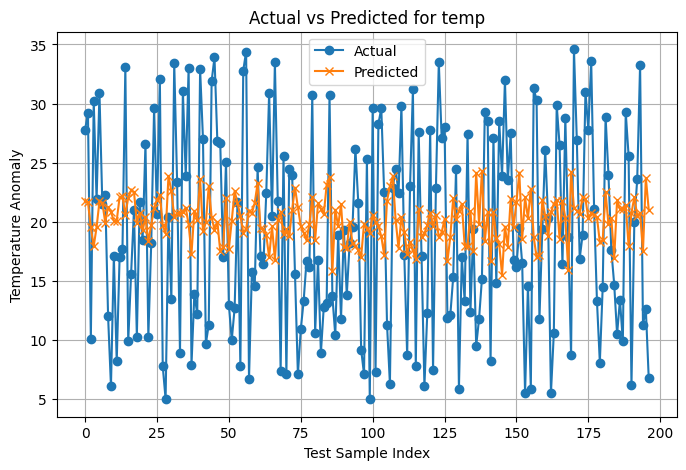

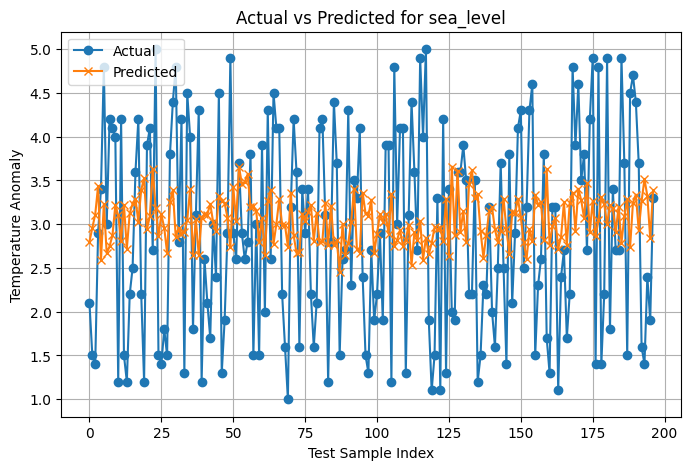

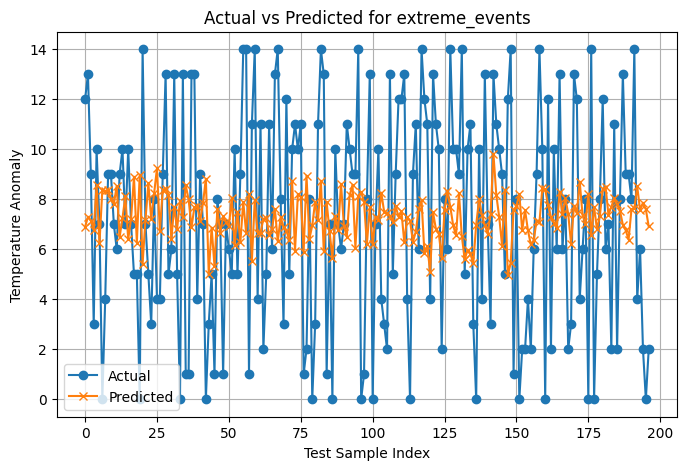

In [17]:
for key, info in models_info.items():
    plt.figure(figsize=(8,5))
    plt.plot(info['y_test'], label="Actual", marker='o')
    plt.plot(info['y_pred'], label="Predicted", marker='x')
    plt.title(f"Actual vs Predicted for {key}")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Temperature Anomaly")
    plt.legend()
    plt.grid(True)
    plt.show()

Top feature importances for Temp model:
 Population                              0.100694
Rainfall (mm)_lag1                      0.092108
Renewable Energy (%)                    0.091221
Avg Temperature (°C)_lag1               0.088968
Rainfall (mm)                           0.085025
CO2 Emissions (Tons/Capita)_rolmean3    0.083028
Forest Area (%)                         0.081817
CO2 Emissions (Tons/Capita)_lag1        0.078825
CO2 Emissions (Tons/Capita)             0.075556
Extreme Weather Events_lag1             0.055709
Year                                    0.053018
year_cos                                0.026896
year_sin                                0.021751
Country_Indonesia                       0.007732
Country_Mexico                          0.006420
dtype: float64


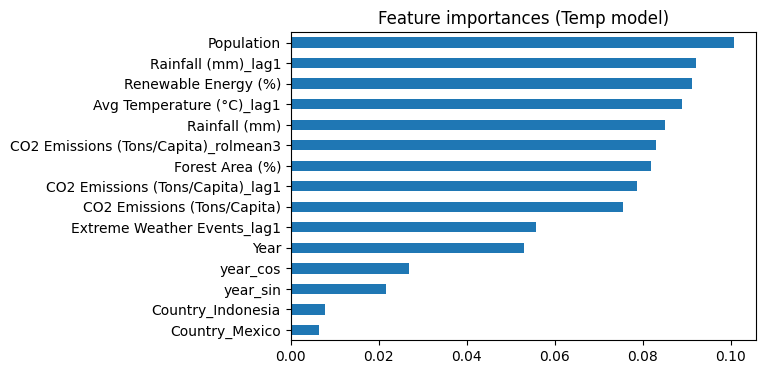

In [18]:
if "temp" in models_info:
    temp_model = models_info["temp"]["pipeline"].named_steps["model"]
    preproc = models_info["temp"]["pipeline"].named_steps["preproc"]
    num_names = features
    cat_encoder = preproc.named_transformers_["cat"]
    if hasattr(cat_encoder, "get_feature_names_out"):
        cat_names = list(cat_encoder.get_feature_names_out(cat_features))
    else:
        cat_names = []
    feat_names = num_names + cat_names
    importances = temp_model.feature_importances_
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(15)
    print("Top feature importances for Temp model:\n", fi)
    fi.plot.barh(figsize=(6,4))
    plt.title("Feature importances (Temp model)")
    plt.gca().invert_yaxis()
    plt.show()


In [19]:
def iterative_forecast_for_country(country, model_pipeline, start_year, years_ahead=10):
    last_row = df[df["Country"] == country].sort_values("Year").iloc[-1].copy()
    future_rows = []
    current = last_row.copy()
    for step in range(1, years_ahead + 1):
        next_year = start_year + step
        current = current.copy()
        current["Year"] = next_year
        if "CO2 Emissions (Tons/Capita)" in current:
            current["CO2 Emissions (Tons/Capita)"] = current["CO2 Emissions (Tons/Capita)"] * 1.01  # 1% growth/year
        if "Population" in current:
            current["Population"] = current["Population"] * 1.01
        X_row = pd.DataFrame([{
            **{f: current[f] for f in features if f in current.index},
            "Country": country
        }])
        pred = model_pipeline.predict(X_row)[0]
        future_rows.append((next_year, pred))
    return pd.DataFrame(future_rows, columns=["Year", "Predicted"])


Iterative forecast for Argentina:
   Year  Predicted
0  2024    12.8450
1  2025    13.0410
2  2026    13.1335
3  2027    13.2050
4  2028    13.4775
5  2029    13.6675
6  2030    14.0275
7  2031    14.0245
8  2032    13.9550
9  2033    14.1390


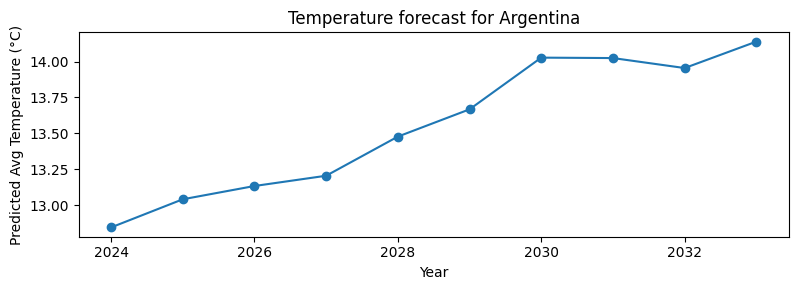

Done. Models and outputs are in /content/models


In [20]:
sample_country = df["Country"].unique()[0]
if "temp" in models_info:
    print(f"\nIterative forecast for {sample_country}:")
    forecast_df = iterative_forecast_for_country(sample_country, models_info["temp"]["pipeline"], df["Year"].max(), years_ahead=FUTURE_YEARS)
    print(forecast_df)
    plt.figure(figsize=(8,3))
    plt.plot(forecast_df["Year"], forecast_df["Predicted"], marker="o")
    plt.title(f"Temperature forecast for {sample_country}")
    plt.xlabel("Year")
    plt.ylabel("Predicted Avg Temperature (°C)")
    plt.tight_layout()
    plt.show()

print("Done. Models and outputs are in", OUT_DIR)